#Week 06

Rishabh Thakur

21020183

Install DEAP. 

In [29]:
!pip install deap

In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import our tools as before, except this time we also include **itertools** and **networks** which contain some nice iterative tools (for creating our test set) and graph drawing functionality, respectively.

In [31]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [43]:
# Genetic Programming constants:
POPULATION_SIZE = 1000
P_CROSSOVER = 0.8
P_MUTATION = 0.01
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 10


Set the random seed. 

In [44]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [45]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [46]:
NUM_INPUTS = 4
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [47]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)
    
# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Add our functions and terminals. This time we are using Boolean operators and values.

In [48]:
# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
#primitiveSet.addPrimitive(operator.xor, 2)
primitiveSet.addPrimitive(operator.not_, 1)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [49]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=primitiveSet)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Set up our population as before

In [50]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [51]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


Run our GP. Notice how much slower this one is, due to the much larger population size. 

In [52]:
population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                     size                    
   	      	------------------------------------------------	---------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std     	avg  	gen	max	min	nevals	std  
0  	1000  	8.008	0  	9  	7  	1000  	0.252856	19.79	0  	56 	4  	1000  	11.28
1  	818   	7.965	1  	9  	6  	818   	0.271616	19.891	1  	58 	1  	818   	11.9214
2  	804   	7.943	2  	9  	6  	804   	0.275229	20.254	2  	68 	1  	804   	12.7103
3  	760   	7.922	3  	9  	6  	760   	0.303177	21.063	3  	69 	2  	760   	13.7813
4  	795   	7.912	4  	9  	6  	795   	0.343884	22.077	4  	93 	2  	795   	14.403 
5  	800   	7.881	5  	9  	6  	800   	0.350484	23.807	5  	100	1  	800   	15.066 
6  	771   	7.832	6  	9  	6  	771   	0.412039	25.298	6  	110	1  	771   	15.8842
7  	812   	7.742	7  	9  	6  	812   	0.481078	27.884	7  	115	1  	812   	17.2321
8  	797   	7.625	8  	9  	6  	797   	0.542563	31.873	8  	108	1  	797   	17.8644
9  	

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

-- Best Individual =  or_(and_(and_(or_(in_1, or_(in_1, and_(in_2, in_0))), in_3), and_(not_(and_(in_2, 0)), or_(in_0, or_(0, in_2)))), not_(and_(or_(or_(and_(0, 1), in_2), not_(or_(and_(or_(and_(not_(and_(in_3, not_(in_0))), and_(not_(in_2), in_1)), or_(and_(not_(and_(in_0, in_3)), or_(not_(not_(1)), in_3)), in_1)), not_(in_1)), and_(and_(0, or_(and_(not_(in_1), not_(in_2)), and_(and_(not_(or_(not_(not_(1)), and_(0, in_3))), and_(or_(1, in_3), and_(in_1, or_(and_(in_3, in_2), and_(in_1, 0))))), and_(0, in_2)))), in_0)))), or_(and_(in_1, in_2), or_(in_0, in_3)))))
-- length=100, height=15
-- Best Fitness =  3.0


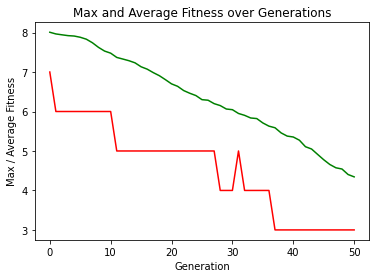

In [53]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

Now, this looks way more interesting than the Symbolic Regression graph as GP is really being made to work hard here!